In [ ]:
import os, json, random
import h5py
import numpy as np
from collections import defaultdict, OrderedDict
from tqdm import tqdm
from tonic.datasets import NCALTECH101

# -------------------------------
# Config
# -------------------------------
SAVE_DIR     = "./ncaltech_subset"           
HDF5_OUT     = "./ncaltech_subset_4k.h5"      # output subset file
TARGET_SAMPLES = 4000                         # small, representative subset
RNG_SEED     = 42

os.makedirs(SAVE_DIR, exist_ok=True)
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)


print("Loading NCALTECH101…")
nc = NCALTECH101(save_to=SAVE_DIR)
print(f"NCALTECH101 total: {len(nc)} | sensor_size={getattr(nc, 'sensor_size', None)}")

def infer_sensor_size(ds, max_checks=50):
    H, W = 0, 0
    checks = min(max_checks, len(ds))
    for i in range(checks):
        ev, _ = ds[i]
        if len(ev) == 0:
            continue
        H = max(H, int(ev['y'].max()) + 1)
        W = max(W, int(ev['x'].max()) + 1)
    return (2, H, W)  # polarity channels, H, W

sensor_size = tuple(nc.sensor_size) if getattr(nc, "sensor_size", None) is not None else infer_sensor_size(nc)
print(f"Using sensor_size={sensor_size}")


all_labels = []
for i in range(len(nc)):
    _, y = nc[i]
    all_labels.append(str(y))

unique_labels = sorted(set(all_labels))  # stable order
label_to_id = OrderedDict((lbl, idx) for idx, lbl in enumerate(unique_labels))
id_to_label = {v: k for k, v in label_to_id.items()}

num_classes = len(label_to_id)
print(f"Detected {num_classes} classes (string labels).")


def make_balanced_indices(dataset, target_samples):
    by_class = defaultdict(list)
    for idx in range(len(dataset)):
        _, y = dataset[idx]
        by_class[str(y)].append(idx)

    classes = sorted(by_class.keys())
    per_class = max(1, target_samples // len(classes))
    min_count = min(len(by_class[c]) for c in classes)
    per_class = min(per_class, min_count)

    chosen = []
    for c in classes:
        chosen.extend(random.sample(by_class[c], per_class))
    random.shuffle(chosen)
    return chosen

subset_idx = make_balanced_indices(nc, TARGET_SAMPLES)
subset_class_ids = [label_to_id[str(nc[i][1])] for i in subset_idx]
print(f"Subset size: {len(subset_idx)} from {len(set(subset_class_ids))} classes")

# -------------------------------
# Save to HDF5
# -------------------------------
with h5py.File(HDF5_OUT, "w") as h5f:
    # store sensor_size as plain ints, label mapping as JSON
    h5f.attrs["sensor_size"] = [int(v) for v in sensor_size]
    h5f.attrs["label_to_id"] = json.dumps(label_to_id)  # retrieve later with json.loads

    grp_events = h5f.create_group("events")
    grp_labels = h5f.create_group("labels")

    for i, ds_idx in enumerate(tqdm(subset_idx, desc="Saving NCALTECH subset")):
        ev, y_str = nc[ds_idx]
        y_id = np.int64(label_to_id[str(y_str)])

        # pack events as float32 array [x, y, t, p]
        arr = np.stack([
            ev['x'].astype(np.float32),
            ev['y'].astype(np.float32),
            ev['t'].astype(np.float32),
            ev['p'].astype(np.float32),
        ], axis=1)

        grp_events.create_dataset(f"sample_{i}", data=arr, compression="gzip")
        grp_labels.create_dataset(f"sample_{i}", data=y_id)

print(f"✅ Saved NCALTECH subset to {HDF5_OUT}")

Loading NCALTECH101…
NCALTECH101 total: 8709 | sensor_size=None
Using sensor_size=(2, 173, 233)
Detected 101 classes (string labels).
Subset size: 3131 from 101 classes


Saving NCALTECH subset: 100%|██████████| 3131/3131 [01:55<00:00, 27.16it/s]


✅ Saved NCALTECH subset to ./ncaltech_subset_4k.h5


## Compression Technique 1 : Grid based Compression

In [ ]:
import os, json
import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm

# ---------------------------
# Paths
# ---------------------------
IN_H5   = "./ncaltech_subset_4k.h5"               
OUT_H5  = "./ncaltech_grid_compressed_4k.h5"
CSV_OUT = "./ncaltech_grid_summary_4k.csv"

GRID_SIZE = (8, 10)   # fewer cells -> more kept overall
TOP_K     = 120       # more events kept per cell

def grid_filter(events_xyti, grid_size=GRID_SIZE, k=TOP_K, sensor_hw=(173, 233)):
    """
    Select top-k latest events per spatial grid cell by timestamp.
    events_xyti: (N,4) float32 array [x, y, t, p]
    grid_size:   (gx, gy) => gx cells across width, gy across height
    sensor_hw:   (H, W)
    returns: indices to keep (np.int64)
    """
    H, W = sensor_hw
    gx, gy = grid_size

    x = np.clip(events_xyti[:, 0].astype(np.int32), 0, W-1)
    y = np.clip(events_xyti[:, 1].astype(np.int32), 0, H-1)
    t = events_xyti[:, 2]

    cell_w = max(1, W // gx)
    cell_h = max(1, H // gy)

    keep = []

    for cx in range(gx):
        x_min, x_max = cx * cell_w, min((cx + 1) * cell_w, W)
        for cy in range(gy):
            y_min, y_max = cy * cell_h, min((cy + 1) * cell_h, H)

            mask = (x >= x_min) & (x < x_max) & (y >= y_min) & (y < y_max)
            idx = np.nonzero(mask)[0]
            if idx.size == 0:
                continue

            if idx.size > k:
                # top-k by timestamp (latest)
                top_local = np.argpartition(t[idx], -k)[-k:]
                keep.extend(idx[top_local])
            else:
                keep.extend(idx)

    return np.asarray(keep, dtype=np.int64) if keep else np.empty((0,), dtype=np.int64)

# ---------------------------
# Running compression
# ---------------------------
summary = []

with h5py.File(IN_H5, "r") as fin:
    # read metadata
    sensor_size = tuple(int(v) for v in fin.attrs["sensor_size"])  # (2, H, W)
    H, W = sensor_size[1], sensor_size[2]
    label_map_json = fin.attrs.get("label_to_id", None)

    g_events = fin["events"]
    g_labels = fin["labels"]
    sample_names = list(g_events.keys())

    with h5py.File(OUT_H5, "w") as fout:
        fout.attrs["sensor_size"] = [int(v) for v in sensor_size]
        if label_map_json is not None:
            fout.attrs["label_to_id"] = label_map_json
        fout.attrs["grid_size"] = GRID_SIZE
        fout.attrs["top_k"] = TOP_K

        out_events  = fout.create_group("events")
        out_labels  = fout.create_group("labels")
        out_discard = fout.create_group("discarded")

        for name in tqdm(sample_names, desc="Grid compressing NCALTECH (milder)"):
            ev = np.array(g_events[name])     # (N,4) -> [x,y,t,p]
            lbl = int(np.array(g_labels[name]).item())

            if ev.shape[0] == 0:
                out_events.create_dataset(name, data=ev, compression="gzip")
                out_labels.create_dataset(name, data=np.int64(lbl))
                out_discard.create_dataset(name, data=ev, compression="gzip")
                summary.append(dict(sample=name, original=0, filtered=0, compression_ratio=np.nan))
                continue

            # normalize timestamps to [0,1]
            tmax = max(1e-8, ev[:, 2].max())
            ev_norm = ev.copy()
            ev_norm[:, 2] /= tmax

            keep_idx = grid_filter(ev_norm, grid_size=GRID_SIZE, k=TOP_K, sensor_hw=(H, W))
            kept = ev[keep_idx] if keep_idx.size else ev[:0]

            # also store discarded (optional; handy for debugging)
            if keep_idx.size:
                mask_all = np.ones(ev.shape[0], dtype=bool)
                mask_all[keep_idx] = False
                disc = ev[mask_all]
            else:
                disc = ev

            out_events.create_dataset(name, data=kept, compression="gzip")
            out_labels.create_dataset(name, data=np.int64(lbl))
            out_discard.create_dataset(name, data=disc, compression="gzip")

            orig = int(ev.shape[0])
            filt = int(kept.shape[0])
            ratio = (orig / filt) if filt > 0 else np.inf
            summary.append(dict(sample=name, original=orig, filtered=filt, compression_ratio=ratio))

# save CSV summary
df = pd.DataFrame(summary)
avg_ratio = df['compression_ratio'].replace([np.inf, -np.inf], np.nan).mean()

print(f"\n✅ Grid compression complete (milder).")
print(f"• HDF5 saved to: {OUT_H5}")
print(f"• Summary saved to: {CSV_OUT}")
df.to_csv(CSV_OUT, index=False)
print(f"Average compression ratio: {avg_ratio:.2f}x  "
      f"(grid={GRID_SIZE}, top_k={TOP_K})")

Grid compressing NCALTECH (milder): 100%|██████████| 3131/3131 [02:35<00:00, 20.19it/s]


✅ Grid compression complete (milder).
• HDF5 saved to: ./ncaltech_grid_compressed_4k.h5
• Summary saved to: ./ncaltech_grid_summary_4k.csv
Average compression ratio: 15.91x  (grid=(8, 10), top_k=120)


## Compression Technique 2 : DBSCAN Compression

In [ ]:
# === NCALTECH DBSCAN compression (quota-per-cluster, hits ~8–10×) ===
import os, h5py, json
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.cluster import DBSCAN

# ---------------------------
# I/O
# ---------------------------
IN_H5   = "./ncaltech_subset_4k.h5"
OUT_H5  = "./ncaltech_dbscan_quota_8x10x.h5"
CSV_OUT = "./ncaltech_dbscan_quota_8x10x_summary.csv"

# ---------------------------
# Targets & knobs
# ---------------------------
TARGET_RATIO       = 8.0       
TOLERANCE_FACTOR   = 0.15      
EPS                = 0.018     
MIN_SAMPLES        = 5
KEEP_STRATEGY      = "recent"  # "recent" or "random" within each cluster

# HDF5 write options
H5_COMP            = "lzf"     # None for fastest I/O, larger files
CHUNK_MAX_ROWS     = 1024
def _choose_chunks(nrows: int):
    return (max(1, min(CHUNK_MAX_ROWS, int(nrows))), 4)

# ---------------------------
# Helper: select multiple representatives per cluster
# ---------------------------
def _select_quota_indices(ev: np.ndarray,
                          labels: np.ndarray,
                          quota: int,
                          strategy: str = "recent") -> np.ndarray:
    """
    Distribute 'quota' across clusters proportional to cluster size (>=1 each),
    then select representatives in each cluster (recent or random).
    labels includes -1 for noise; treat noise as its own cluster.
    Returns indices into ev of size ~quota (capped at N).
    """
    N = len(ev)
    if quota >= N:
        return np.arange(N, dtype=np.int64)

    # group by cluster id
    clusters = {}
    for i, c in enumerate(labels):
        clusters.setdefault(int(c), []).append(i)

    # drop any empty
    clusters = {k: np.asarray(v, dtype=np.int64) for k, v in clusters.items() if len(v) > 0}
    K = len(clusters)
    if K == 0:
        # degenerate: keep a thin slice
        keep = max(1, quota)
        return np.arange(min(keep, N), dtype=np.int64)

    sizes = {k: len(v) for k, v in clusters.items()}
    total = sum(sizes.values())

    # start with 1 per cluster
    alloc = {k: 1 for k in clusters.keys()}
    remaining = max(0, quota - K)

    if remaining > 0 and total > 0:
        # proportional addition
        proportional = {k: sizes[k] / total for k in clusters.keys()}
        add = {k: int(np.floor(proportional[k] * remaining)) for k in clusters.keys()}
        added = sum(add.values())
        # give leftovers to largest clusters
        if added < remaining:
            order = sorted(clusters.keys(), key=lambda k: sizes[k], reverse=True)
            for k in order[:(remaining - added)]:
                add[k] += 1
        for k in clusters.keys():
            alloc[k] += add[k]

    # sample within each cluster
    keep_idx = []
    for k, idxs in clusters.items():
        m = alloc[k]
        if m >= len(idxs):
            keep_idx.extend(idxs)
            continue

        if strategy == "recent":
            t = ev[idxs, 2]
            order = np.argsort(t)[-m:]
            keep_idx.extend(idxs[order])
        elif strategy == "random":
            sel = np.random.choice(idxs, m, replace=False)
            keep_idx.extend(sel)
        else:
            keep_idx.extend(idxs[:m])

    if len(keep_idx) > N:
        keep_idx = keep_idx[:N]
    return np.asarray(keep_idx, dtype=np.int64)

# ---------------------------
# Core compression
# ---------------------------
def compress_dbscan_quota(ev_xyti: np.ndarray, H: int, W: int) -> np.ndarray:
    N = ev_xyti.shape[0]
    if N == 0:
        return ev_xyti[:0]

    # normalize for clustering
    tmax = float(max(1e-8, ev_xyti[:, 2].max()))
    X = np.stack([
        ev_xyti[:, 0] / W,
        ev_xyti[:, 1] / H,
        ev_xyti[:, 2] / tmax
    ], axis=1).astype(np.float32)

    labels = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, n_jobs=-1).fit(X).labels_

    quota = max(1, int(np.ceil(N / TARGET_RATIO)))
    keep_idx = _select_quota_indices(ev_xyti, labels, quota, strategy=KEEP_STRATEGY)
    return ev_xyti[keep_idx]

# ---------------------------
# Run over file
# ---------------------------
def main():
    summary = []

    with h5py.File(IN_H5, "r") as fin:
        sensor_size = tuple(int(v) for v in fin.attrs["sensor_size"])  # (2,H,W)
        H, W = sensor_size[1], sensor_size[2]
        label_map_json = fin.attrs.get("label_to_id", None)

        g_e = fin["events"]
        g_l = fin["labels"]
        keys = list(g_e.keys())

        with h5py.File(OUT_H5, "w") as fout:
            fout.attrs["sensor_size"] = [int(v) for v in sensor_size]
            fout.attrs["dbscan_eps"] = float(EPS)
            fout.attrs["dbscan_min_samples"] = int(MIN_SAMPLES)
            fout.attrs["target_ratio"] = float(TARGET_RATIO)
            if label_map_json is not None:
                fout.attrs["label_to_id"] = label_map_json

            out_e = fout.create_group("events")
            out_l = fout.create_group("labels")

            for name in tqdm(keys, desc="DBSCAN quota NCALTECH (~8–10×)"):
                ev  = np.array(g_e[name], dtype=np.float32)
                lbl = int(np.array(g_l[name]).item())

                kept = compress_dbscan_quota(ev, H, W)

                # safe HDF5 write
                if kept.shape[0] > 0:
                    out_e.create_dataset(
                        name,
                        data=kept,
                        compression=H5_COMP,
                        chunks=_choose_chunks(kept.shape[0])
                    )
                else:
                    out_e.create_dataset(name, shape=(0, 4), dtype="float32")
                out_l.create_dataset(name, data=np.int64(lbl))

                orig = int(ev.shape[0])
                filt = int(kept.shape[0])
                ratio = (orig / filt) if filt > 0 else np.inf
                summary.append(dict(sample=name, original=orig, filtered=filt, compression_ratio=ratio))

    df = pd.DataFrame(summary)
    df.to_csv(CSV_OUT, index=False)

    mean_ratio = df["compression_ratio"].replace([np.inf, -np.inf], np.nan).dropna().mean()
    print("\n✅ DBSCAN (quota) complete.")
    print(f"• HDF5 saved to: {OUT_H5}")
    print(f"• Summary saved to: {CSV_OUT}")
    print(f"• Average compression ratio: {mean_ratio:.2f}× (target ≈ {TARGET_RATIO}×)")

if __name__ == "__main__":
    main()

DBSCAN quota NCALTECH (~8–10×): 100%|██████████| 3131/3131 [10:44<00:00,  4.86it/s]


✅ DBSCAN (quota) complete.
• HDF5 saved to: ./ncaltech_dbscan_quota_8x10x.h5
• Summary saved to: ./ncaltech_dbscan_quota_8x10x_summary.csv
• Average compression ratio: 8.00× (target ≈ 8.0×)


## Evaluation Metrics for the 2 Compression Methods

   Method  Compression Ratio (x)  Compression Ratio Std  Events per Sample  \
0    Grid                 15.914                   7.25           7370.668   
1  DBSCAN                  8.000                   0.00          14715.063   

   Events per Sample Std  Data Retention (%)  Data Retention Std  \
0               1580.878               7.848               4.408   
1               7612.796              12.500               0.001   

   Compressed Size (MB)  Original Size (MB)  Samples  
0               369.241             5897.15     3131  
1               737.166             5897.15     3131  


/var/folders/kj/9p6pr1nj245gdw0g16fpzh1c0000gn/T/ipykernel_79416/1216700016.py:178: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxdata, labels=methods, patch_artist=True,
/var/folders/kj/9p6pr1nj245gdw0g16fpzh1c0000gn/T/ipykernel_79416/1216700016.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.96])


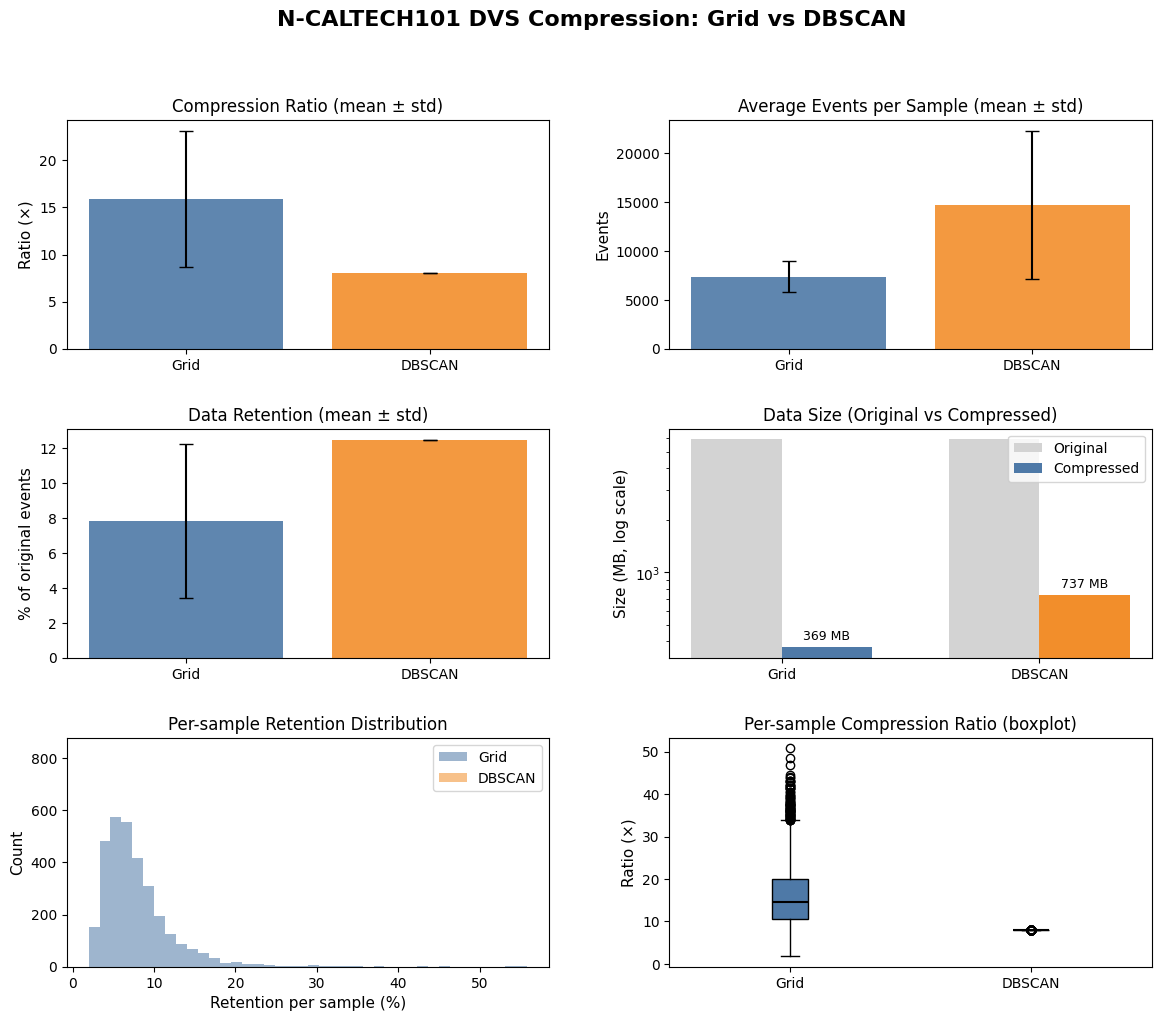


✅ Saved summary table → ./ncaltech_grid_vs_dbscan_summary.csv
✅ Saved figure         → ./ncaltech_grid_vs_dbscan_figure.png


In [13]:
# === NCALTECH101-DVS: Grid vs DBSCAN (comparison) ===
# Reads your two summary CSVs, builds a consolidated table, and plots 6 panels.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------- INPUTS (edit if you changed filenames) -------------
GRID_CSV   = "./ncaltech_grid_summary_4k.csv"
DBSCAN_CSV = "./ncaltech_dbscan_quota_8x10x_summary.csv"

# ------------- OUTPUTS -------------
OUT_TABLE  = "./ncaltech_grid_vs_dbscan_summary.csv"
OUT_FIG    = "./ncaltech_grid_vs_dbscan_figure.png"

# ------------- CONSTANTS -------------
BYTES_PER_EVENT = 16  # float32 x,y,t,p  (4*4 bytes)

TITLE  = "N-CALTECH101 DVS Compression: Grid vs DBSCAN"
COLORS = {"Grid":"#4E79A7", "DBSCAN":"#F28E2B"}

# ---------- helpers ----------
def load_results(path: str) -> pd.DataFrame:
    """
    Robust loader for summary CSVs with columns:
      sample, original, filtered, compression_ratio
    (Case-insensitive; drops inf/NaN rows; computes retention %.)
    """
    df = pd.read_csv(path)
    # normalize column access (case-insensitive)
    cols_lower = {c.lower(): c for c in df.columns}

    def pick(name):
        # find first column whose lower == name
        for c in df.columns:
            if c.lower() == name:
                return c
        raise ValueError(f"Missing column '{name}' in {path}")

    c_sample = cols_lower.get("sample", None)
    c_orig   = pick("original")
    c_filt   = pick("filtered")
    c_ratio  = pick("compression_ratio")

    out = pd.DataFrame({
        "sample": df[c_sample] if c_sample else np.arange(len(df)),
        "original": pd.to_numeric(df[c_orig], errors="coerce"),
        "filtered": pd.to_numeric(df[c_filt], errors="coerce"),
        "compression_ratio": pd.to_numeric(df[c_ratio], errors="coerce"),
    })
    out["retention_pct"] = 100.0 * (out["filtered"] / out["original"].replace(0, np.nan))
    out = out.replace([np.inf, -np.inf], np.nan).dropna(subset=["compression_ratio","filtered","original"])
    return out

df_grid   = load_results(GRID_CSV)
df_dbscan = load_results(DBSCAN_CSV)

def summarise(df: pd.DataFrame, label: str) -> dict:
    total_orig = float(df["original"].sum())
    total_filt = float(df["filtered"].sum())

    mean_ratio = float(df["compression_ratio"].mean())
    std_ratio  = float(df["compression_ratio"].std())

    mean_events = float(df["filtered"].mean())
    std_events  = float(df["filtered"].std())

    mean_ret = float(df["retention_pct"].mean())
    std_ret  = float(df["retention_pct"].std())

    original_mb   = (total_orig * BYTES_PER_EVENT) / 1e6
    compressed_mb = (total_filt * BYTES_PER_EVENT) / 1e6

    return {
        "Method": label,
        "Compression Ratio (x)": mean_ratio,
        "Compression Ratio Std": std_ratio if np.isfinite(std_ratio) else 0.0,
        "Events per Sample": mean_events,
        "Events per Sample Std": std_events if np.isfinite(std_events) else 0.0,
        "Data Retention (%)": mean_ret,
        "Data Retention Std": std_ret if np.isfinite(std_ret) else 0.0,
        "Compressed Size (MB)": compressed_mb,
        "Original Size (MB)": original_mb,
        "Samples": len(df)
    }

summary_rows = [
    summarise(df_grid,   "Grid"),
    summarise(df_dbscan, "DBSCAN"),
]
df_summary = pd.DataFrame(summary_rows)

# Rounded copy for the CSV/table
df_summary_rounded = df_summary.copy()
for c in df_summary.columns:
    if df_summary[c].dtype.kind in "fc":
        df_summary_rounded[c] = df_summary[c].round(3)

print(df_summary_rounded)
df_summary_rounded.to_csv(OUT_TABLE, index=False)

# ---------- FIGURES ----------
plt.rcParams.update({
    "figure.figsize": (14, 11),
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10
})

fig = plt.figure(constrained_layout=False, figsize=(14, 11))
gs  = fig.add_gridspec(3, 2, height_ratios=[1,1,1], hspace=0.35, wspace=0.25)
fig.suptitle(TITLE, fontsize=16, fontweight="bold", y=0.98)

methods = ["Grid", "DBSCAN"]
xpos = np.arange(len(methods))
bar_colors = [COLORS["Grid"], COLORS["DBSCAN"]]

# Panel A: Compression ratio (mean ± std)
ax = fig.add_subplot(gs[0,0])
means = df_summary["Compression Ratio (x)"].values
errs  = df_summary["Compression Ratio Std"].values
ax.bar(xpos, means, yerr=errs, capsize=5, color=bar_colors, alpha=0.9)
ax.set_xticks(xpos); ax.set_xticklabels(methods)
ax.set_ylabel("Ratio (×)")
ax.set_title("Compression Ratio (mean ± std)")

# Panel B: Events per sample (mean ± std)
ax = fig.add_subplot(gs[0,1])
means = df_summary["Events per Sample"].values
errs  = df_summary["Events per Sample Std"].values
ax.bar(xpos, means, yerr=errs, capsize=5, color=bar_colors, alpha=0.9)
ax.set_xticks(xpos); ax.set_xticklabels(methods)
ax.set_ylabel("Events")
ax.set_title("Average Events per Sample (mean ± std)")

# Panel C: Data retention % (mean ± std)
ax = fig.add_subplot(gs[1,0])
means = df_summary["Data Retention (%)"].values
errs  = df_summary["Data Retention Std"].values
ax.bar(xpos, means, yerr=errs, capsize=5, color=bar_colors, alpha=0.9)
ax.set_xticks(xpos); ax.set_xticklabels(methods)
ax.set_ylabel("% of original events")
ax.set_title("Data Retention (mean ± std)")

# Panel D: Data size comparison (log scale with labels)
ax = fig.add_subplot(gs[1,1])
orig_sizes = df_summary["Original Size (MB)"].values
comp_sizes = df_summary["Compressed Size (MB)"].values
width = 0.35
ax.bar(xpos - width/2, orig_sizes, width, color="lightgray", label="Original")
bars = ax.bar(xpos + width/2, comp_sizes, width, color=bar_colors, label="Compressed")
ax.set_yscale("log")
ax.set_xticks(xpos); ax.set_xticklabels(methods)
ax.set_ylabel("Size (MB, log scale)")
ax.set_title("Data Size (Original vs Compressed)")
ax.legend()
for b in bars:
    h = b.get_height()
    ax.annotate(f"{h:.0f} MB", xy=(b.get_x()+b.get_width()/2, h),
                xytext=(0,3), textcoords="offset points",
                ha="center", va="bottom", fontsize=9)

# Panel E: Per-sample retention distribution (overlaid histograms)
ax = fig.add_subplot(gs[2,0])
ax.hist(df_grid["retention_pct"],   bins=40, alpha=0.55, color=COLORS["Grid"],   label="Grid")
ax.hist(df_dbscan["retention_pct"], bins=40, alpha=0.55, color=COLORS["DBSCAN"], label="DBSCAN")
ax.set_xlabel("Retention per sample (%)")
ax.set_ylabel("Count")
ax.set_title("Per-sample Retention Distribution")
ax.legend()

# Panel F: Per-sample compression ratio (boxplots)
ax = fig.add_subplot(gs[2,1])
boxdata = [df_grid["compression_ratio"].values, df_dbscan["compression_ratio"].values]
bp = ax.boxplot(boxdata, labels=methods, patch_artist=True,
                medianprops=dict(color="black", linewidth=1.5))
bp["boxes"][0].set_facecolor(COLORS["Grid"])
bp["boxes"][1].set_facecolor(COLORS["DBSCAN"])
ax.set_ylabel("Ratio (×)")
ax.set_title("Per-sample Compression Ratio (boxplot)")

fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.savefig(OUT_FIG, dpi=300)
plt.show()

print(f"\n✅ Saved summary table → {OUT_TABLE}")
print(f"✅ Saved figure         → {OUT_FIG}")